## catboost_classifier
Creates Catboost multiclass classifiers
with hyperparameter optimalization

# 0. Initialization

## Options

In [5]:
#using csv from new version of scraper
new_version = True
#using 502525 split, probably takes a bit longer for hyperopt
split502525 = False
#using optimization (else values from old optimization -> only valid if using 'TotalF1' evaluation metric!
optimization = True
#using long optimization
#NOTE: is much longer!
long_optimization = False
#save model
save_model = True
#evaluation metric
eval_m = 'TotalF1'
#task type, GPU is faster, bit might crash your kernel
task_t= 'CPU'

## Dependencies

In [6]:
import numpy as np #math
import pandas as pd #dataframes
import catboost as ct #main machine learning

import sklearn as sk #statistics

import seaborn as sn #plots
import matplotlib.pyplot as plt  #plots
import shap #plots

from hyperopt import hp, fmin, tpe, STATUS_OK #hyperparameter optimalisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Main function definitions

## Objective
Objective function for hyperopt for hyperparameter optimalisation

In [7]:
obj_call_count = 0
best_loss = np.inf

def objective(space):
    global obj_call_count, best_loss

    obj_call_count += 1
    
    #train model with parameters from space
    model = ct.CatBoostClassifier(iterations = 500, #not too many
                                  learning_rate = space['learning_rate'],
                                  depth = int(space['depth']),
                                  rsm = space['rsm'],
                                  loss_function = 'MultiClass',
                                  eval_metric = eval_m,
                                  l2_leaf_reg = space['l2_leaf_reg'],
                                  #crashes kernel but might work on your pc
                                  #should increase speed
                                  devices= '1',
                                  task_type= task_t,
                                  random_seed=42,
                                  verbose=False,
                                  od_type='Iter', #overfitting detector to stop early
                                  od_wait=100
                                  )
    model.fit(val)
    
    #obtain loss
    y_pred = model.predict_proba(x_train)
    loss = sk.metrics.log_loss(r_train, y_pred)
    #if better loss found for new parameters
    if loss<best_loss: 
        best_loss = loss

    return{'loss':loss, 'status': STATUS_OK }

# 1. Data

## Read in data
and some extra analysis

In [8]:
data = pd.read_csv("tweets_final.csv") 
print(len(data))
data.head(5)

1932


,Unnamed: 0,Unnamed: 0.1,id_str,Screen Name,User Name,Time,Followers,num_retweets,num_likes,date,...,reply,quote,tweet_type,num_emojis,emoji_polarity,length,party_affiliation,days_since_post,time_day,day_week
0,0,0,1.210867e+18,pvdabelgie,PVDA België,2019-12-28 10:17:26,10460,5,19,2019-12-28,...,False,False,normal,0,0.0,191,pvdabelgie,5,10,5
1,1,1,1.209871e+18,pvdabelgie,PVDA België,2019-12-25 16:16:48,10460,14,30,2019-12-25,...,False,False,normal,0,0.0,87,pvdabelgie,8,16,2
2,2,2,1.207912e+18,pvdabelgie,PVDA België,2019-12-20 06:33:56,10460,13,43,2019-12-20,...,False,False,normal,0,0.0,109,pvdabelgie,13,6,4
3,3,3,1.207627e+18,pvdabelgie,PVDA België,2019-12-19 11:39:33,10460,3,4,2019-12-19,...,False,False,normal,0,0.0,65,pvdabelgie,14,11,3
4,4,4,1.206876e+18,pvdabelgie,PVDA België,2019-12-17 09:58:19,10460,21,51,2019-12-17,...,False,False,normal,0,0.0,83,pvdabelgie,16,9,1


In [9]:
from datetime import datetime
from datetime import date
from sklearn.preprocessing import RobustScaler, StandardScaler
robust = RobustScaler(quantile_range = (0.1,0.9))
scaler = StandardScaler()

#target
scal = data.num_likes/data.Followers*100
if split502525 == True:
    target_med = scal.ge(0.092778723) #medium 50
    target_good = scal.ge(0.31737635) #good 75
else:
    target_med = scal.ge(0.043159258) #medium 33
    target_good = scal.ge(0.210837023) #good 66
data['target'] = 0
data.loc[target_med == True, 'target'] = 1
data.loc[target_good == True, 'target'] = 2

#numerical features
feature_cols = ['time_day', 'day_week', 'num_hashtags', 'num_hashtags_trending', 'num_mentions', 'num_urls', 'num_emojis', 'emoji_polarity', 'subjectivity', 'polarity', 'length', 'days_since_post'] 
X = data.loc[:, feature_cols].astype('float')

#categorical and boolean features
feature_cols = ['reply', 'quote', 'category', 'party_affiliation', 'media_type']

X[feature_cols] = data.loc[:, feature_cols].astype('category')
target = data['target'].astype('category')

X.head(8)

,time_day,day_week,num_hashtags,num_hashtags_trending,num_mentions,num_urls,num_emojis,emoji_polarity,subjectivity,polarity,length,days_since_post,reply,quote,category,party_affiliation,media_type
0,10.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.25,0.182292,191.0,5.0,False,False,andere,pvdabelgie,nothing
1,16.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,87.0,8.0,False,False,sociaal,pvdabelgie,nothing
2,6.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,109.0,13.0,False,False,politiek,pvdabelgie,nothing
3,11.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,65.0,14.0,False,False,ecologie,pvdabelgie,nothing
4,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.000000,83.0,16.0,False,False,politiek,pvdabelgie,nothing
5,11.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.25,-0.083333,209.0,17.0,False,False,economie,pvdabelgie,photo
6,10.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.60,-0.600000,68.0,17.0,False,False,zorg,pvdabelgie,nothing
7,15.0,3.0,4.0,0.0,2.0,1.0,0.0,0.0,0.00,0.000000,185.0,21.0,True,True,ecologie,pvdabelgie,photo


## Data manipulations

In [10]:
X['category'] = X['category'].fillna('andere')

#Scaling is not necesary in this type of model, if you want it, change cell to 'code'


X['days_since_post'] = scaler.fit_transform(X.days_since_post.values.reshape(-1, 1))
X['length'] = scaler.fit_transform(X.length.values.reshape(-1, 1))
X['num_urls'] = scaler.fit_transform(X.num_urls.values.reshape(-1, 1))
X['num_hashtags'] = scaler.fit_transform(X.num_hashtags.values.reshape(-1, 1))
X['num_hashtags_trending'] = scaler.fit_transform(X.num_hashtags_trending.values.reshape(-1, 1))
X['num_mentions'] = scaler.fit_transform(X.num_mentions.values.reshape(-1, 1))
X['num_emojis'] = scaler.fit_transform(X.num_emojis.values.reshape(-1, 1))
X['emoji_polarity'] = scaler.fit_transform(X.emoji_polarity.values.reshape(-1, 1))
X['polarity'] = scaler.fit_transform(X.polarity.values.reshape(-1, 1))
X.head(10)
print(len(X))
print(X)

In [11]:
#emoji_polarity was determined to be useless 
X = X.drop(['emoji_polarity'], axis=1)
#take into account the cyclical nature of weeks and days
X['time_day'] = np.sin(2*np.pi*X['time_day']/24)
X['day_week'] = np.sin(2*np.pi*X['day_week']/6)

In [12]:
#get non-numeric or boolean features
cat_feat_ind = np.where(X.dtypes != float)[0]
print(cat_feat_ind)

[11 12 13 14 15]


In [13]:
# Randomly split off a test set of approximately 20% of the data
# Split of rest of the data in a validation set for hyperopt (20% of the rest) and a train set (80% of the rest)
test_fraction = 0.2
x_t, x_test, r_t, r_test = train_test_split(X,
                                            target,
                                            stratify = target,
                                            test_size = test_fraction,
                                            random_state=42)

x_train, x_val, r_train, r_val = train_test_split(x_t,
                                                  r_t,
                                                  stratify = r_t,
                                                  test_size = test_fraction,
                                                  random_state=42)
x_train.head(5)

,time_day,day_week,num_hashtags,num_hashtags_trending,num_mentions,num_urls,num_emojis,subjectivity,polarity,length,days_since_post,reply,quote,category,party_affiliation,media_type
47,-0.707107,1.224647e-16,1.0,0.0,0.0,1.0,0.0,0.4000,0.10,95.0,70.0,False,False,zorg,pvdabelgie,nothing
1404,0.258819,0.000000e+00,0.0,0.0,3.0,1.0,0.0,0.7125,0.35,260.0,24.0,False,False,politiek,de_NVA,video
1057,0.965926,-2.449294e-16,3.0,2.0,4.0,1.0,0.0,0.9000,-0.65,132.0,67.0,False,False,politiek,openvld,photo
1074,-0.258819,8.660254e-01,0.0,0.0,2.0,0.0,0.0,0.6500,-0.15,71.0,16.0,True,False,politiek,openvld,nothing
164,-0.500000,1.224647e-16,0.0,0.0,3.0,1.0,0.0,0.0000,0.00,73.0,14.0,True,True,andere,pvdabelgie,nothing


# 2. Hyperparameter optimalization

In [14]:
train = ct.Pool(data=x_train,label=r_train, cat_features=cat_feat_ind)

val = ct.Pool(data=x_val,label=r_val, cat_features=cat_feat_ind)

In [15]:
if optimization == True:
    if long_optimization == True:
        #create hyperopt space
        space ={
            'depth': hp.quniform("depth", 6, 14, 1),#long
            'rsm': hp.uniform ('rsm', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -4.5, -0.1),#long
            'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
           }
        #run hyperopt to select best parameters
        best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 200)
        
        
    else:
        #create hyperopt space
        if split502525 == True:
            space ={
                'depth': hp.quniform("depth", 9, 13, 1),
                'rsm': hp.uniform ('rsm', 0.75, 1.0),
                'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
                'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
               }
        else:
            space ={
                'depth': hp.quniform("depth", 4, 12, 1),
                'rsm': hp.uniform ('rsm', 0.75, 1.0),
                'learning_rate': hp.loguniform('learning_rate', -3.0, -0.7),
                'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
                
               }
        #run hyperopt to select best parameters
        best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 100)
 

else: #no optimization, takes values from old optimization
    if split502525 == True:
        best = {'depth': 9.0, 'l2_leaf_reg': 7.300256193096466, 'learning_rate': 0.06596340263322384, 'rsm': 0.8916406285083096}
    else:
        best = {'depth': 6.0, 'l2_leaf_reg': 8.592194444324123, 'learning_rate': 0.04984672268861198, 'rsm': 0.7742768150761888}
print('-'*50)
print('Best parameters:')
print( best )
print('\n\n')

100%|██████████| 100/100 [07:30<00:00,  4.50s/it, best loss: 0.8293582402770862]
--------------------------------------------------
Best parameters:
{'depth': 6.0, 'l2_leaf_reg': 6.271609895652211, 'learning_rate': 0.05068540109192645, 'rsm': 0.7546706902995657}





# 3. Model

In [16]:
#train multiple models on train set using best parameters, with different seeds to take average prediction
model1 = ct.CatBoostClassifier(iterations = 2500,
                               learning_rate = best['learning_rate'],
                               l2_leaf_reg = best['l2_leaf_reg'],
                               depth = best['depth'],
                               rsm = best['rsm'],
                               loss_function = 'MultiClass',
                               eval_metric = eval_m,
                               use_best_model = True,
                               random_seed = 42,
                               logging_level = 'Silent')
model1.fit(train, eval_set=val)
#model1.fit(train)
#parameters same as model 1
model2 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=23,
                               logging_level='Silent')
model2.fit(train, eval_set=val)
#model2.fit(train)
model3 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=12,
                               logging_level='Silent')
model3.fit(train, eval_set=val)
#model3.fit(train)

model4 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=43,
                               logging_level='Silent')
model4.fit(train, eval_set=val)
#model4.fit(train)

model5 = ct.CatBoostClassifier(iterations=2500,
                               learning_rate=best['learning_rate'],
                               l2_leaf_reg=best['l2_leaf_reg'],
                               depth=best['depth'],
                               rsm=best['rsm'],
                               loss_function= 'MultiClass',
                               eval_metric=eval_m,
                               use_best_model = True,
                               #random_seed=54,
                               logging_level='Silent')
model5.fit(train, eval_set=val)
#model5.fit(train)

#predict using test set
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)
y_pred3 = model3.predict(x_test)
y_pred4 = model4.predict(x_test)
y_pred5 = model5.predict(x_test)


In [17]:
#print(model1.eval_metrics(val, ['TotalF1']))

In [18]:
y_comp = pd.concat([pd.Series(np.ravel(y_pred1)), pd.Series(np.ravel(y_pred2)), pd.Series(np.ravel(y_pred3)), pd.Series(np.ravel(y_pred4)),pd.Series(np.ravel(y_pred5))],axis=1)
y_mean = y_comp.mode(axis=1).iloc[:, 0] #choose prediction that is most frequent per tweet
y_mean.head(8) #show 8 first predictions of the mean predictor
y_comp.head(8) #show 8 first predictions of the 5 predictors


,0,1,2,3,4
0,2.0,2.0,2.0,2.0,2.0
1,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,2.0,2.0,2.0
3,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0
7,1.0,2.0,2.0,2.0,2.0


# 4. Analysis

## Feature importance

In [19]:
model1.get_feature_importance(prettified=True)

,Feature Id,Importances
0,party_affiliation,20.792150
1,reply,14.695027
2,category,10.955256
3,length,8.798250
4,media_type,8.132133
5,days_since_post,8.114714
6,subjectivity,5.605355
7,time_day,4.979117
8,num_mentions,4.654002
9,polarity,4.002494


## Performance metrics
Accuracy and confusion matrix for the single and mean predictor

In [20]:
from catboost.utils import get_confusion_matrix
print("Accuracy for mean predictor")
accuracy_mean = sk.metrics.accuracy_score(r_test, y_mean)
print(accuracy_mean)
print("Confusion matrix for mean predictor")
#confusion_mean = sk.metrics.confusion_matrix(r_test, y_mean, labels=['bad', 'medium', 'good'])
confusion_mean = sk.metrics.confusion_matrix(r_test, y_mean, labels=[0, 1, 2])
print(confusion_mean)
print("Accuracy for single predictor")
accuracy_1 = sk.metrics.accuracy_score(r_test, np.ravel(y_pred1))
print(accuracy_1)
print("Confusion matrix for single predictor")
#confusion_1 = sk.metrics.confusion_matrix(r_test, np.ravel(y_pred1), labels=['bad', 'medium', 'good'])
confusion_1 = sk.metrics.confusion_matrix(r_test, np.ravel(y_pred1), labels=[0, 1, 2])
print(confusion_1)
#only for 2 classes
#precision = sk.metrics.precision_score(r_test, np.ravel(y_mean))
#print(precion)

Accuracy for mean predictor
0.6459948320413437
Confusion matrix for mean predictor
[[92 31  7]
 [28 66 30]
 [ 9 32 92]]
Accuracy for single predictor
0.6537467700258398
Confusion matrix for single predictor
[[94 30  6]
 [29 67 28]
 [ 6 35 92]]


## Visual confusion matrix

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


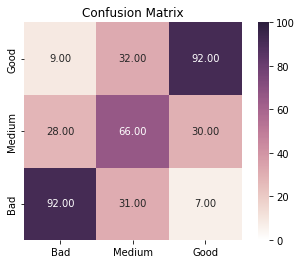

In [22]:
df_cm = pd.DataFrame(confusion_mean, 
  index = [ 'Bad', 'Medium', 'Good'],
  columns = ['Bad', 'Medium', 'Good'])

fig = plt.figure()

plt.clf()
plt.title('Confusion Matrix')
plt.yticks([0.5,1.5,2.5], [ 'Bad', 'Medium', 'Good'],va='center')

ax = fig.add_subplot(111)
ax.set_aspect(1)

cmap = sn.cubehelix_palette(light=1, as_cmap=True)

pl = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
pl.invert_yaxis()

if split502525 == True:
    plt.savefig('confusion_matrix50.png', dpi=100, bbox_inches='tight' )
else:
    plt.savefig('confusion_matrix33.png', dpi=100, bbox_inches='tight' )
#plt.close()

## Shap plots
For feature importance

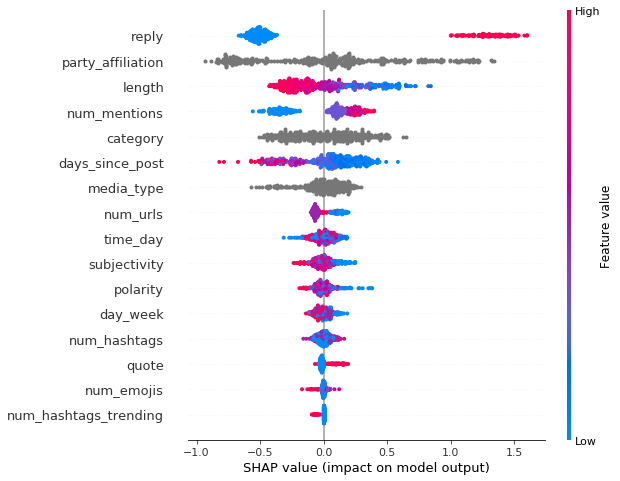

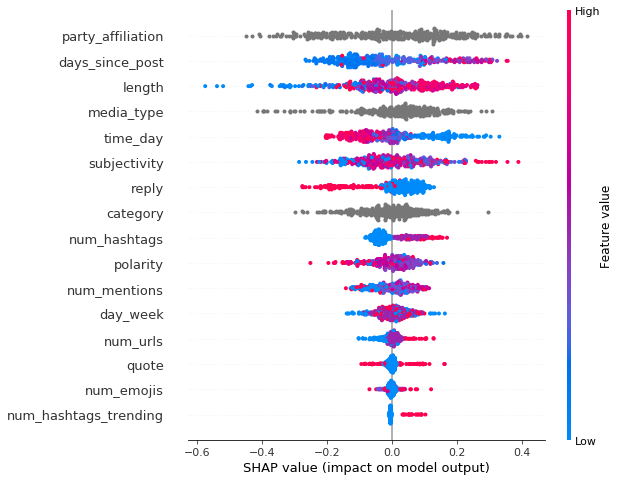

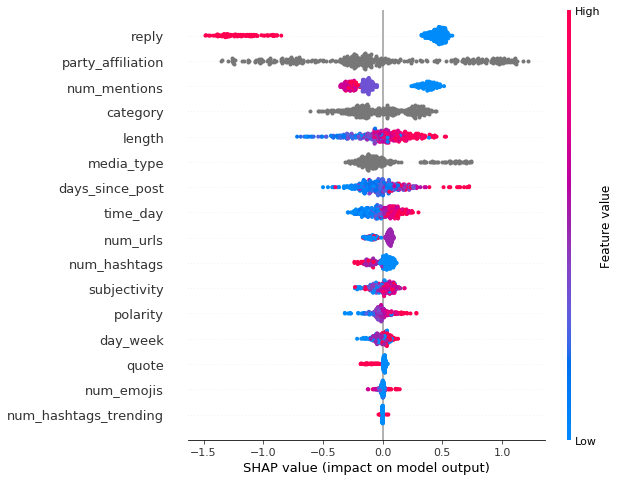

In [23]:
shap.initjs()
shap_values = model1.get_feature_importance(ct.Pool(x_test, r_test, cat_features=cat_feat_ind), type='ShapValues')

shap_values = shap_values[:,:,:-1]
shap.summary_plot(shap_values[:,0], x_test)#class 0
shap.summary_plot(shap_values[:,1], x_test)#class 1
shap.summary_plot(shap_values[:,2], x_test)#class 2

# 5. Save Models

In [25]:
if save_model == True:
    
    pool = ct.Pool(x_train, r_train, cat_features=cat_feat_ind)


    if split502525 == True:
        #Catboost binary model for fast predictions
        model1.save_model('models/model1-50.cbm', format = "cbm", pool = pool) #pool necessary because categorical features
        model2.save_model('models/model2-50.cbm', format = "cbm", pool = pool)
        model3.save_model('models/model3-50.cbm', format = "cbm", pool = pool)
        model4.save_model('models/model4-50.cbm', format = "cbm", pool = pool)
        model5.save_model('models/model5-50.cbm', format = "cbm", pool = pool)
    else:
        model1.save_model('models/model1-33.cbm', format = "cbm", pool = pool)
        model2.save_model('models/model2-33.cbm', format = "cbm", pool = pool)
        model3.save_model('models/model3-33.cbm', format = "cbm", pool = pool)
        model4.save_model('models/model4-33.cbm', format = "cbm", pool = pool)
        model5.save_model('models/model5-33.cbm', format = "cbm", pool = pool)